In [1]:
%load_ext autoreload
%autoreload 2

# Simulacion de distribuciones por radio censal

**A continuación se detalla:**

1. Estimación del total de viviendas/hogares por categorías a partir del total registrado en el Precenso 2020.

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [3]:
import os

os.environ["CENSAR_CARTO_DIR"] = "/resources/bucket/censar_carto/"
os.environ["CENSAR_DATA_DIR"] = "/resources/bucket/censar_data/"

In [4]:
import matplotlib.pyplot as plt

In [5]:
from CENSAr.datasources import (
    tipoviv_radios_prov,
    radios_prov,
    radios_precenso_2020,
    radios_eph_censo_2010,
)

2023-05-22 21:10:00.134 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 21:10:00.136 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 21:10:00.136 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 21:10:00.137 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 21:10:00.137 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-05-22 21:10:00.137 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [6]:
from CENSAr.modeling_tools import (
    tracts_2020_to_2010,
    tracts_2010_to_2001,
    simulate_cat_var,
)

In [7]:
# GEOMETRIAS
envolvente = radios_eph_censo_2010(aglo_idx="12")
corrientes_2001 = radios_prov(year=2001, prov="corrientes", mask=envolvente)
corrientes_2010 = radios_prov(year=2010, prov="corrientes", mask=envolvente)
corrientes_2020 = radios_precenso_2020(
    geo_filter={"prov": "18", "depto": "021"}, mask=None
)

[21:10:00] INFO     /resources/bucket/censar_carto//radios_eph_json.zip                          ]8;id=369192;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=80838;file:///workspace/CENSAr/datasources.py#111\111]8;;\

In [8]:
# TABLAS REDATAM - HOGARES/VIVIENDAS
tipo_2001 = tipoviv_radios_prov(
    year=2001, prov="corrientes", var_types={"LINK": "object"}
)
tipo_2001_geo = corrientes_2001.set_index("link").join(tipo_2001.set_index("link"))
tipo_2010 = tipoviv_radios_prov(
    year=2010, prov="corrientes", var_types={"link": "object"}
)
tipo_2010_geo = corrientes_2010.set_index("link").join(tipo_2010.set_index("link"))

[21:10:15] INFO     loading                                                                      ]8;id=268768;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=417400;file:///workspace/CENSAr/datasources.py#121\121]8;;\
                    `/resources/bucket/censar_data/tipo_vivienda_radios_corrientes_2001.csv`                       

           INFO     loading                                                                      ]8;id=768408;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=554949;file:///workspace/CENSAr/datasources.py#121\121]8;;\
                    `/resources/bucket/censar_data/tipo_vivienda_radios_corrientes_2010.csv`                       

In [9]:
corrientes_2020_ = tracts_2020_to_2010(
    tracts_2020_gdf=corrientes_2020, tracts_2010_gdf=corrientes_2010
)

# Verifico que todos los radios 2020 cuenten con referencia 2010
corrientes_2020_["link_2010"].isna().unique()

# Radios 2020 con referencias 2010 y 2001
tracts_corrientes_2020 = tracts_2010_to_2001(tracts_2020_gdf=corrientes_2020_)

/workspace/CENSAr/modeling_tools.py:410: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  tracts_2020_gdf_rep["geometry"] = tracts_2020_gdf_rep.geometry.centroid
/workspace/CENSAr/modeling_tools.py:423: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  NaN2020["geometry"] = NaN2020.geometry.centroid
/usr/local/lib/python3.10/dist-packages/geopandas/array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


           INFO     loadding `/resources/bucket/censar_data/corrientes_conversion_010.csv`       ]8;id=828446;file:///workspace/CENSAr/datasources.py\datasources.py]8;;\:]8;id=686081;file:///workspace/CENSAr/datasources.py#173\173]8;;\

In [10]:
# Distribucion de categorias por radio censal
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="2010",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname="casilla",
    tot_colname="total_viviendas",
)

tracts_corrientes_2020["casilla_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

In [11]:
from CENSAr.plots import compare_chropleths

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


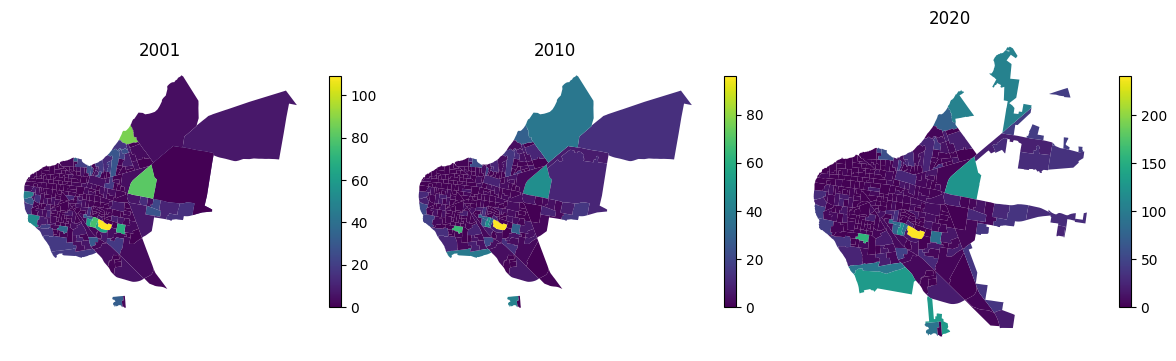

In [12]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "casilla_2020"],
    titles=[2001, 2010, 2020],
)

In [13]:
# Con catname uso la distribucion de una variable en 2001 y de otra en 2010 en funcion del diccionario que pasamos como parametro
simulated_distribution = simulate_cat_var(
    gdf_var_01=tipo_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname={"2001": "casilla", "2010": "rancho"},
    tot_colname="total_viviendas",
)

tracts_corrientes_2020["informal_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

In [14]:
tracts_corrientes_2020["informal_2020"].sum()

3412.0

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


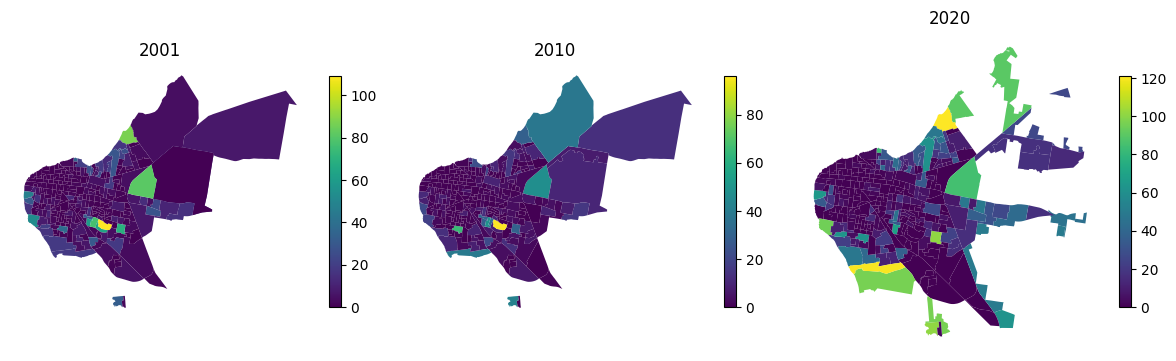

In [15]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "informal_2020"],
    titles=[2001, 2010, 2020],
)

In [16]:
from CENSAr.datasources import servurban_radios_prov

In [17]:
servurban_2001 = servurban_radios_prov(prov="corrientes", var_types={"link": "object"})
servurban_2001_geo = tipo_2001_geo.join(servurban_2001.set_index("link"))

In [18]:
servurban_2001_geo.columns

Index(['geometry', 'casa a', 'casa b', 'rancho', 'casilla', 'departamento',
       'pieza en inquilinato', 'pieza en hotel o pension',
       'local no construido para habitacion', 'vivienda movil', 'en la calle',
       'total', 'pavimento_si', 'pavimento_no', 'pavimento_sa',
       'recoleccion_residuos_si', 'recoleccion_residuos_no',
       'recoleccion_residuos_sa', 'trans_pub_300m_si', 'trans_pub_300m_no',
       'trans_pub_300m_sa', 'telefono_publico_300m_si',
       'telefono_publico_300m_no', 'telefono_publico_300m_sa'],
      dtype='object')

In [19]:
tipo_2010_geo.columns

Index(['geometry', 'casa', 'rancho', 'casilla', 'departamento',
       'pieza en inquilinato', 'pieza en hotel familiar o pension',
       'local no construido para habitacion', 'vivienda movil', 'en la calle',
       'total'],
      dtype='object')

In [20]:
simulated_distribution = simulate_cat_var(
    gdf_var_01=servurban_2001_geo,
    gdf_var_10=tipo_2010_geo,
    base_year="0110",
    forecast_year="2020",
    forecast_gdf=tracts_corrientes_2020,
    pct_val=2.5,
    catname={"2001": "pavimento_no", "2010": "rancho"},
    tot_colname="total_viviendas",
)


tracts_corrientes_2020["informal_2020"] = tracts_corrientes_2020["link"].map(
    simulated_distribution
)

{'legend': True, 'legend_kwds': {'shrink': 0.3}}


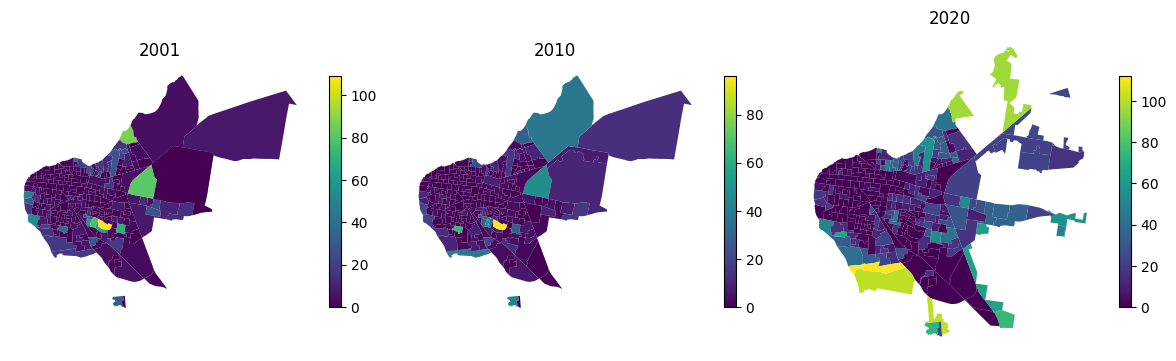

In [23]:
compare_chropleths(
    tipo_2001_geo,
    tipo_2010_geo,
    tracts_corrientes_2020,
    column=["casilla", "casilla", "informal_2020"],
    titles=[2001, 2010, 2020],
)